In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Modules for xT models
from itertools import combinations_with_replacement
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

In [3]:
# Modules for plotting
import matplotlib.pyplot as plt
from mplsoccer import PyPizza, Radar, FontManager
from scipy import stats

In [38]:
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/SourceSerifPro-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/RobotoSlab%5Bwght%5D.ttf')

CREDIT = 'Created by Olof Ekborg-Tanner (@olofekborg).'
SOURCE = 'Data from Wyscout.'

In [8]:
def get_successful_dribbles(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df_sd_player: dataframe
        dataframe with number of successful dribbles.
    """
    
    # Get attacking duels
    df_duels = df.loc[df.subEventName == 'Ground attacking duel']
    # Get dribbles
    df_dribbles = df_duels.loc[df_duels.apply(lambda x: ({'id':501} in x.tags) | ({'id':502} in x.tags) | ({'id':503} in x.tags) | ({'id':504} in x.tags), axis=1)]
    # Get won dribbles attempts
    df_sd = df_dribbles.loc[df_dribbles.apply(lambda x: {'id': 703} in x.tags, axis=1)]

    # Sum by player
    df_sd_player = df_sd.groupby(['playerId']).count().eventId.reset_index()
    df_sd_player.rename(columns={'eventId':'successful_dribbles'}, inplace=True)
    
    return df_sd_player

In [9]:
def get_passes_into_box(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df_box_pass_player: dataframe
        dataframe with number of passes into the box.
    """
    
    # Get passes
    df_passes = df.loc[df.eventName == 'Pass']
    # Get coordinates
    df_passes['x'] = df_passes.positions.apply(lambda cell: (cell[0]['x']))
    df_passes['y'] = df_passes.positions.apply(lambda cell: (100 - cell[0]['y']))
    df_passes['end_x'] = df_passes.positions.apply(lambda cell: (cell[1]['x']))
    df_passes['end_y'] = df_passes.positions.apply(lambda cell: (100 - cell[1]['y']))
    
    # Filter accurate passes
    df_accurate_passes = df_passes.loc[df_passes.apply (lambda x: {'id':1801} in x.tags, axis=1)]
    # Get passes into box (coordinates fetched from https://dataglossary.wyscout.com/pitch_coordinates/)
    df_box_pass = df_accurate_passes.loc[(df_accurate_passes.end_x > 84) & (df_accurate_passes.end_y > 19) & (df_accurate_passes.end_y < 81)]
    
    # Sum by player
    df_box_pass_player = df_box_pass.groupby(['playerId']).count().eventId.reset_index()
    df_box_pass_player.rename(columns={'eventId':'passes_into_box'}, inplace=True)
    
    return df_box_pass_player

In [10]:
def get_shots_in_box(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df_box_shots_player: dataframe
        dataframe with number of shots in the box.
    """
    
    # Get passes
    df_shots = df.loc[df.eventName == 'Shot']
    # Change coordinates
    df_shots['x'] = df_shots.positions.apply(lambda cell: (cell[0]['x']))
    df_shots['y'] = df_shots.positions.apply(lambda cell: (100 - cell[0]['y']))
    
    # Get shots in the box (coordinates fetched from https://dataglossary.wyscout.com/pitch_coordinates/)
    df_box_shots = df_shots.loc[(df_shots.x > 84) & (df_shots.y > 19) & (df_shots.y < 81)]
    
    # Sum by player
    df_box_shots_player = df_box_shots.groupby(['playerId']).count().eventId.reset_index()
    df_box_shots_player.rename(columns={'eventId':'shots_in_box'}, inplace=True)
    
    return df_box_shots_player

In [12]:
def shot_foot(tags):
    """
    Parameters
    ----------
    tags : list
        list of dictionaries with Wyscout tags.

    Returns
    -------
    foot: string
        string with descripition of Wyscout tag for which foot the action was performed with.
    """

    if {'id':401} in tags:
        return 'left' 
    elif {'id':402} in tags:
        return 'right'
    else:
        return None

In [13]:
def get_xG(df, player_foot):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.
    player_foot : dataframe
        dataframe with preferred foot for each player.

    Returns
    -------
    df_xg: dataframe
        dataframe with Expected Goals added per event.
    """

    df_xg = df.copy()

    df_shots = df_xg.loc[df_xg['eventName'] == 'Shot']

    # Normalise coordinates to a more standard pitch format.
    df_shots['x'] = df_shots.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    df_shots['y'] = df_shots.positions.apply(lambda cell: (cell[0]['y']) * 68/100)
    df_shots['c'] = df_shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)

    # Calculate distance and angle.
    angle = np.arctan(7.32 * df_shots['x'] / (df_shots['x']**2 + df_shots['c']**2 - (7.32/2)**2))
    df_shots['Distance'] = np.sqrt(df_shots['x']**2 + df_shots['x']**2)
    df_shots['Angle'] = np.where(angle > 0, angle, angle + np.pi)

    # Filter out goals.
    df_shots['Goal'] = df_shots.tags.apply(lambda x: True if {'id':101} in x else False)

    # Separate headers from non-headers.
    headers = df_shots.loc[df_shots.apply(lambda x: {'id':403} in x.tags, axis=1)]
    non_headers = df_shots.drop(index=headers.index)

    # Extract which foot the shot was taken with.
    non_headers['shot_foot'] = non_headers.apply(lambda x: shot_foot(x.tags), axis=1)
    non_headers = non_headers.reset_index().merge(player_foot, on='playerId', how='left').set_index('index')

    # Separate shots taken with preferred foot and weaker foot for different models.
    best_foot = non_headers.loc[non_headers.shot_foot == non_headers.foot]
    secondary_foot = non_headers.loc[non_headers.shot_foot != non_headers.foot]


    # Headers model
    headers_model = smf.glm(formula='Goal ~ Distance + Angle' , data=headers, family=sm.families.Binomial()).fit()
    # Models for Best & Secondary foot
    best_foot_model = smf.glm(formula='Goal ~ Distance + Angle' , data=best_foot, family=sm.families.Binomial()).fit()
    second_foot_model = smf.glm(formula='Goal ~ Distance + Angle' , data=secondary_foot, family=sm.families.Binomial()).fit()

    # Penalty model
    penalties = df_xg.loc[df_xg['subEventName'] == 'Penalty']
    #treating penalties like shots 
    penalties['x'] = 11
    #calculate distance and angle
    penalties['Distance'] = 11
    penalties['Angle'] = np.arctan(7.32 * penalties['x'] / (penalties['x']**2 - (7.32/2)**2))

    penalties['Goal'] = penalties.tags.apply(lambda x: True if {'id':101} in x else False)

    penalties_model = smf.glm(formula="Goal ~ Distance + Angle" , data=penalties, 
                               family=sm.families.Binomial()).fit()


    # Assign xG to all events. Default is 0.
    df_xg['xG'] = 0

    # Assign xG headers
    b_head = headers_model.params
    xG = 1 / (1 + np.exp(b_head[0] + b_head[1]*headers['Distance'] + b_head[2]*headers['Angle'])) 
    headers = headers.assign(xG=xG)
    for index, row in headers.iterrows():
        df_xg.at[index, 'xG'] = row['xG']

    # Assign xG for Best & Secondary foot
    b_bfoot = best_foot_model.params
    xG = 1 / (1 + np.exp(b_bfoot[0] + b_bfoot[1]*best_foot['Distance'] + b_bfoot[2]*best_foot['Angle'])) 
    best_foot = best_foot.assign(xG=xG)
    for index, row in best_foot.iterrows():
        df_xg.at[index, 'xG'] = row['xG']

    b_sfoot = second_foot_model.params
    xG = 1 / (1 + np.exp(b_sfoot[0] + b_sfoot[1]*secondary_foot['Distance'] + b_sfoot[2]*secondary_foot['Angle'])) 
    secondary_foot = secondary_foot.assign(xG=xG)
    for index, row in secondary_foot.iterrows():
        df_xg.at[index, 'xG'] = row['xG']

    b_pen = penalties_model.params
    xG = 1 / (1 + np.exp(b_pen[0] + b_pen[1]*penalties['Distance'] + b_pen[2]*penalties['Angle'])) 
    penalties = penalties.assign(xG=xG)
    for index, row in penalties.iterrows():
        df_xg.at[index, 'xG'] = row['xG']

    return df_xg

### Create Possession chains for xT model

In [14]:
def change_coordinates(df):
    
    # Remove strange position values.
    df = df.loc[df.apply(lambda x: len(x.positions)==2, axis=1)]
    # Normalise coordinates to a more standard pitch format.
    # Add distance from y to center of the pitch (c). 
    df['x0'] = df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    df['c0'] = df.positions.apply(lambda cell: abs(50 - cell[0]['y']) * 68/100)
    df['x1'] = df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    df['c1'] = df.positions.apply(lambda cell: abs(50 - cell[1]['y']) * 68/100)
    # Assign center of goal (105, 0) as end of the shot
    df.loc[df['eventName'] == 'Shot', 'x1'] = 105
    df.loc[df['eventName'] == 'Shot', 'c1'] = 0
    
    return df


In [15]:
def prepare_possession_chain(df):
    
    next_event = df.shift(-1, fill_value=0)
    df['nextEvent'] = next_event['subEventName']
    df['kickedOut'] = df.apply(lambda x: 1 if x.nextEvent == 'Ball out of the field' else 0, axis=1)
    
    # Filter out intrerruptions.
    interruption = df.loc[df['eventName'] == 'Interruption']
    df = df.drop(interruption.index)
    # Filter out lost duels, both attacking and defending.
    lost_duels = df.loc[df['eventName'] == 'Duel']
    lost_duels = lost_duels.loc[lost_duels.apply(lambda x: {'id':1802} in x.tags, axis=1)]
    df = df.drop(lost_duels.index)
    # Filter ball out of the field.
    out_of_ball = df.loc[df['subEventName'] == 'Ball out of the field']
    df = df.drop(out_of_ball.index)
    # Filter out goalkeeper actions.
    goalies = df.loc[df['subEventName'].isin(['Goalkeeper leaving line', 'Save attempt', 'Reflexes'])]
    df = df.drop(goalies.index)
    
    return df

In [16]:
def isolateChains(df):
  
    df['nextTeamId'] = df.shift(-1, fill_value=0)['teamId']
    
    chain_team = df.iloc[0]['teamId']
    period = df.iloc[0]['matchPeriod']
    stop_criterion = 0
    chain = 0
    df['possesion_chain'] = 0
    df['possesion_chain_team'] = 0
    
    for i, row in df.iterrows():
        # Add value.
        df.at[i, 'possesion_chain'] = chain
        df.at[i, 'possesion_chain_team'] = chain_team
        # If pass not accurate/lost duel, add 1 to stop criterion.
        if row['eventName'] == 'Pass' or row['eventName'] == 'Duel':
            if row['teamId'] == chain_team and {'id': 1802} in row['tags']:
                    stop_criterion += 1
            if row['teamId'] != chain_team and {'id': 1801} in row['tags']:
                    stop_criterion += 1
        # If ball intercepted properly, add 2.
        if row['eventName'] == 'Others on the ball':
               if row['teamId'] == row['nextTeamId']:
                   stop_criterion += 2
        # If shot, foul or offside, add 2 to stop criterion.
        if row['eventName'] in ['Shot', 'Foul', 'Offside']:
                stop_criterion += 2
        # If ball out of field, add 2
        if row['kickedOut'] == 1:
                stop_criterion += 2
        # Criterion for stopping when half ended
        if row['matchPeriod'] != period:
                chain += 1
                stop_criterion = 0
                chain_team = row['teamId']
                period = row['matchPeriod'] 
                df.at[i, 'possesion_chain'] = chain
                df.at[i, 'possesion_chain_team'] = chain_team
        # Possession chain ended. Start next.
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['nextTeamId']
    return df

In [18]:
def prepareChains(df):
    
    df['shot_end'] = 0
    # Get number of chains.
    no_chains = max(df['possesion_chain'].unique())
    indicies = []
    for i in range(no_chains + 1):
        # All events get possesion chain
        possesion_chain_df = df.loc[df['possesion_chain'] == i]
        # Check if the possesion chain is not empty.
        if len(possesion_chain_df) > 0:
            # Check if ended with shot.
            if possesion_chain_df.iloc[-1]['eventName'] == 'Shot':
                # Assign values.
                df.loc[df['possesion_chain'] == i, 'shot_end'] = 1
                xG = possesion_chain_df.iloc[-1]['xG']
                df.loc[df['possesion_chain'] == i, 'xG'] = xG
                # Check if the previous ones did not end with foul.
                k = i-1
                if k > 0:
                    try:
                        prev = df.loc[df['possesion_chain'] == k] 
                        # Create a loop if e.g. 2 chains before and 1 chain before didn't end with shot.
                        while prev.iloc[-1]['eventName'] == 'Foul':
                            # Assign values.
                            df.loc[df['possesion_chain'] == k, 'xG'] = xG
                            df.loc[df['possesion_chain'] == k, 'shot_end'] = 1
                            k = k-1
                            prev = df.loc[df['possesion_chain'] == k]
                    except:
                        k = k-1
            # Get indices of events made by possesion team.           
            team_indicies = possesion_chain_df.loc[possesion_chain_df['teamId'] == possesion_chain_df.teamId.mode().iloc[0]].index.values.tolist()
            indicies.extend(team_indicies)    
    
    df = df.loc[indicies]
    return df 

In [19]:
def prepare_xT_model(df_possession_chain, var):
    """
    Parameters
    ----------
    df : dataframe
        dataframe possession chains for all matches.
    var : list
        list of variables to make non-linear combinations of.

    Returns
    -------
    df_sd: dataframe
        dataframe with  with non-linear variables for Successful Dribbles.
    """

    # Generate non-linear combinations.
    inputs = []
    # One variable combinations.
    inputs.extend(combinations_with_replacement(var, 1))
    # 2 variable combinations.
    inputs.extend(combinations_with_replacement(var, 2))

    # Create new columns
    for i in inputs:
        if len(i) > 1:
            column = ''
            x = 1
            for c in i:
                # Set column name as the combination of variables.
                column += c
                # Multiply values in column.
                x = x * df_possession_chain[c]
            # Add new column to df_possession_chain.
            df_possession_chain[column] = x
            # Add column to model variables.
            var.append(column)


    # Filter out duels only.
    df_duels = df_possession_chain.loc[df_possession_chain.subEventName == 'Ground attacking duel']
    # Get dribbles
    df_dribbles = df_duels.loc[df_duels.apply(lambda x: ({'id':501} in x.tags) | ({'id':502} in x.tags) | ({'id':503} in x.tags) | ({'id':504} in x.tags), axis=1)]
    # Get won dribbles attempts
    df_sd = df_dribbles.loc[df_dribbles.apply(lambda x: {'id': 703} in x.tags, axis=1)]

    return df_sd

In [20]:
def shot_pred_model(X, y):
    """
    Parameters
    ----------
    X : dataframe
        dataframe of independent features.
    y : array
        array of the target variable.

    Returns
    -------
    rf: Random Forest model
        model trained to predict the probability of a shot in the end of a possession chain.
    """

    # Split the data into training and testing set to train the model.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123, stratify=y)


    # Create a Random Forest model to classify whether there's a shot at the end of the possesion chain.
    rf = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=10,random_state=123)
    # Train it on the data.
    rf.fit(X_train, y_train)

    # rf.score(X_test, y_test) gives 0.8161 which is decent for such a simple model.
    # rf.score(X_test, y_test) gives 0.8282 so it predicts well on test data as well.
    # roc_auc_score(y_test, y_pred_prob[::,1]), i.e. roc_auc score when extending from the binary classification to the probability of a shot in the end, is 0.8202,
    # which indicates that the model actually predicts well for both classes and not only chosing the most common one.

    return rf

In [21]:
def xG_model(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe to train model on.

    Returns
    -------
    lr: Linear Regression model
        simple model trained to predict the xG of a shot.
    """

    # OLS to predict 
    shot_ended = df.loc[df['shot_end'] == 1]
    X = shot_ended[var].values
    y = shot_ended['xG'].values

    lr = LinearRegression()
    lr.fit(X, y)

    return lr


### Plotting functions

In [26]:
def get_summary_data_for_plot(country):
    """
    Parameters
    ----------
    country : string
        country to create dataset for

    Returns
    -------
    df_summary: dataset
        dataset with the total value for all metrics added for each player.
    """
    # Load event data from the country and minutes played per game.
    df_event = pd.read_json(f'data/Wyscout/events_{country}.json')
    df_mins = pd.read_json(f'data/Wyscout/minutes_played_per_game_{country}.json').drop('shortName', axis=1)
    df_mins_clean = df_players.filter(items=['wyId', 'shortName','position','foot','teamId']).merge(df_mins, left_on='wyId', right_on='playerId')


    # Create DataFrame with the player data of interest and total minutes played during the season.
    df = df_mins_clean.groupby(['playerId','shortName','position','foot', 'teamId']).sum().minutesPlayed.reset_index()


    # Get xG and xA for each shot.
    df_xg = get_xG(df_event, df[['playerId','foot']])
    df_xg['prevEvent'] = df_xg['eventName'].shift(1)
    df_xg['prevPlayerId'] = df_xg['playerId'].shift(1).fillna(-1).astype(int) # Need to set a non-existing id (-1) for NaNs.

    # Remove penalties for npxG.
    df_xg_player = df_xg.loc[df_xg['subEventName'] != 'Penalty'].groupby(['playerId'])['xG'].sum().reset_index()
    df_xg_player.rename(columns={'xG': 'npxG'}, inplace=True)

    df_xa = df_xg.loc[df_xg.prevEvent == 'Pass']
    df_xa_player = df_xa.groupby(['prevPlayerId'])['xG'].sum().reset_index()
    df_xa_player.rename(columns={'xG': 'xA', 'prevPlayerId': 'playerId'}, inplace=True)


    return df.merge(
        get_successful_dribbles(df_event), on='playerId').merge(
        get_passes_into_box(df_event), on='playerId').merge(
        get_shots_in_box(df_event), on='playerId').merge(
        df_xg_player, on='playerId').merge(
        df_xa_player, on='playerId')

In [72]:
def plot_pizza(playerId, data, dark_mode=True, add_title=True, league_name='', save_fig=False):
    """
    Parameters
    ----------
    playerId : integer
        numerical id for player to plot.
    data : dataset
        dataset with all the metric values.
    dark_mode : boolean
        switches colors to be adjust to a dark or light background.
    add_title : boolean
        switches between showing the title and not (for the report).
    league_name : string
        a lazy way to change name of the league in the plot.
    save_fig : boolean
        switches between saving the plot or not.

    Returns
    -------
    None
    """

    slice_color = '#cf0d13'

    if dark_mode:
        background_color = '#222222'
        title_color = '#F2F2F2'
        last_circle_color = '#F2F2F2'
        blank_space_color = '#222222'
    else:
        background_color = 'white'
        last_circle_color = '#000000'
        title_color = '#000000'
        blank_space_color = '#C5C5C5'


    if add_title:
        param_size = 16
        values_size = 16
    else:
        param_size = 26
        values_size = 20

    player = data.loc[data.playerId == playerId]

    value_columns = player[['passes_into_box_per90', 'xA_per90', 'shots_in_box_per90', 'npxG_per90','successful_dribbles_per90', 'xT_per90']]
    values = [round(player[column].iloc[0],2) for column in value_columns]
    percentiles = [int(stats.percentileofscore(data[column], player[column].iloc[0])) for column in value_columns]


    names =['Passes into Box', 'xA', 'Shots in the Box', 'non-penalty xG','Successful Dribbles', 'xT - Dribbles']
    slice_colors = [slice_color] * len(values)
    text_colors = ['white'] * len(values)

    # PIZZA PLOT
    baker = PyPizza(
        params=names,  
        min_range=None,
        max_range=None,               # list of parameters
        background_color=background_color,
        straight_line_color='#000000',  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=1,               # linewidth of last circle
        last_circle_color=last_circle_color,
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )
    #making pizza for our data
    fig, ax = baker.make_pizza(
        percentiles,           # list of values
        figsize=(10, 10),      # adjust figsize according to your need
        param_location=110,
        slice_colors=slice_colors,
        color_blank_space=[blank_space_color] * len(values),
        value_colors=text_colors,
        value_bck_colors=slice_colors, # where the parameters will be added
        kwargs_slices=dict(
            facecolor='cornflowerblue', edgecolor='#000000',
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color=title_color, fontsize=param_size,
            fontproperties=font_bold.prop, va='center'
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color='#000000', fontsize=values_size,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor='#000000', facecolor='cornflowerblue',
                boxstyle='round,pad=0.2', lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    #putting text
    texts = baker.get_value_texts()
    for i, text in enumerate(texts):
        text.set_text(str(values[i]))


    player_name = player.shortName.values[0]
    team_name = df_teams.loc[df_teams.wyId == player.teamId.values[0]].name.values[0]


    if add_title:
        # add title
        fig.text(
            0.515, 0.97, f'{player_name} per 90', size=28,
            ha='center', fontproperties=font_bold.prop, color=title_color
        )

        # add subtitle
        fig.text(
            0.515, 0.942,
            f'{team_name} | {league_name} | Season 2017-18',
            size=20,
            ha='center', fontproperties=font_italic.prop, color=title_color
        )

        # add credits
        fig.text(
            0.99, 0.005, f'{CREDIT}\n{SOURCE}', size=12,
            fontproperties=font_italic.prop, color=title_color,
            ha='right'
        )

    if save_fig:
        plt.savefig(f'radar_{player_name.split(" ")[-1]}.png', bbox_inches='tight', dpi=300, transparent=True)

    plt.show()

    return None

### Run code

In [24]:
print('----------------')

# Load teams data from Wyscout and encode Unicode characters.
print('Load Wyscout data...')
df_teams = pd.read_json('data/Wyscout/teams.json')
df_teams['teamName'] = df_teams.name.apply(lambda name: name.encode('utf=8').decode('unicode-escape'))

# Load player data from Wyscout and encode Unicode characters.
df_players = pd.read_json('data/Wyscout/players.json')
df_players['position'] = df_players['role'].apply(lambda x: x['name'])
df_players['shortName'] = df_players.shortName.apply(lambda name: name.encode('utf=8').decode('unicode-escape'))

print('Load prepared possession chains...')
# Load prepared possession chains for both Premier League (PL) and Bundesliga (BL).
df_possession_pl = pd.read_json('possession_chains/possession_chains_pl.json')
df_possession_bl = pd.read_json('possession_chains/possession_chains_bl.json')

var = ['x0', 'x1', 'c0', 'c1']

# Prepare data for training xT models.
df_sd_pl = prepare_xT_model(df_possession_pl, var)
df_sd_bl = prepare_xT_model(df_possession_bl, ['x0', 'x1', 'c0', 'c1'])


# Separate the target variable y from the set of independentfeatures X.
X_pl = df_sd_pl[var].values
y_pl = df_sd_pl.shot_end.values

X_bl = df_sd_bl[var].values
y_bl = df_sd_bl.shot_end.values

# Train shot prediction model on PL dataset, using Random Forest.
print('Train shot prediction model...')
rf = shot_pred_model(X_pl, y_pl)

# Add the predicted probability of a shot in the end of the possesion chains.
# I use the same model to have a consistent assesment of the quality of the scoring chance, 
# even though a different model might perform better when trained on Bundesliga data
df_sd_pl['shot_prob'] = rf.predict_proba(X_pl)[::,1]
df_sd_bl['shot_prob'] = rf.predict_proba(X_bl)[::,1]


# Train xG prediction model using Linear Regression. Once again we train on PL dataset.
print('Train xG prediction model...')
lr = xG_model(df_sd_pl)

# Add the predicted xG.
df_sd_pl['xG_pred'] = lr.predict(X_pl)
df_sd_bl['xG_pred'] = lr.predict(X_bl)


# Assign xT as the product of shot probability and predicted xG.
df_sd_pl['xT'] = df_sd_pl['xG_pred'] * df_sd_pl['shot_prob']
df_sd_bl['xT'] = df_sd_bl['xG_pred'] * df_sd_bl['shot_prob']


----------------
Load Wyscout data...
Load prepared possession chains...
Train shot prediction model...
Train xG prediction model...


## Plot spiders

### AFC Bournemouth

In [27]:
# Summaries all metrics in one dataset.
summary_pl = get_summary_data_for_plot('England').merge(
    df_sd_pl.groupby('playerId').xT.sum(), on='playerId'
)

# Normalise to minutes played.
summary_per_90_pl = summary_pl.loc[(summary_pl.position == 'Midfielder') & (summary_pl.minutesPlayed > 900),['playerId','shortName','position','foot','teamId']]
for column in summary_pl.columns[6:]:
    summary_per_90_pl[f'{column}_per90'] = summary_pl.apply(lambda x: x[column] * 90 / x['minutesPlayed'], axis=1)


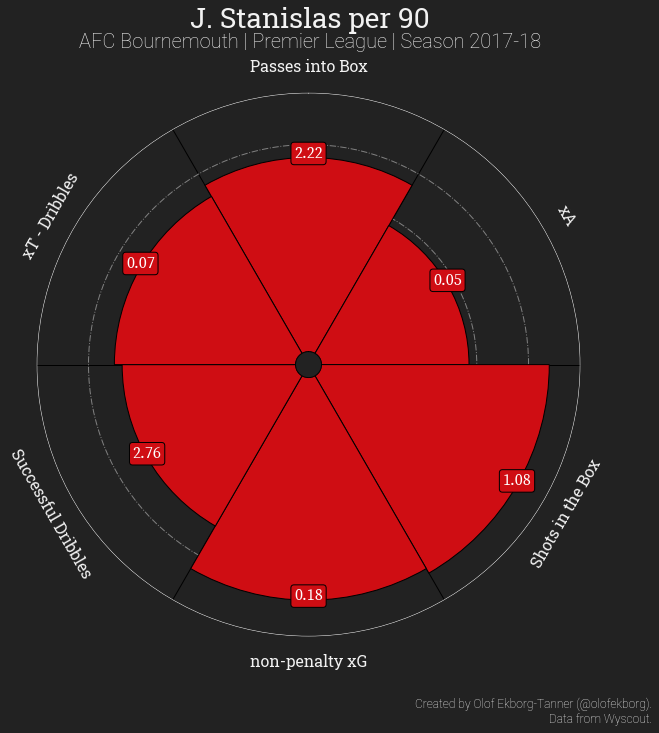

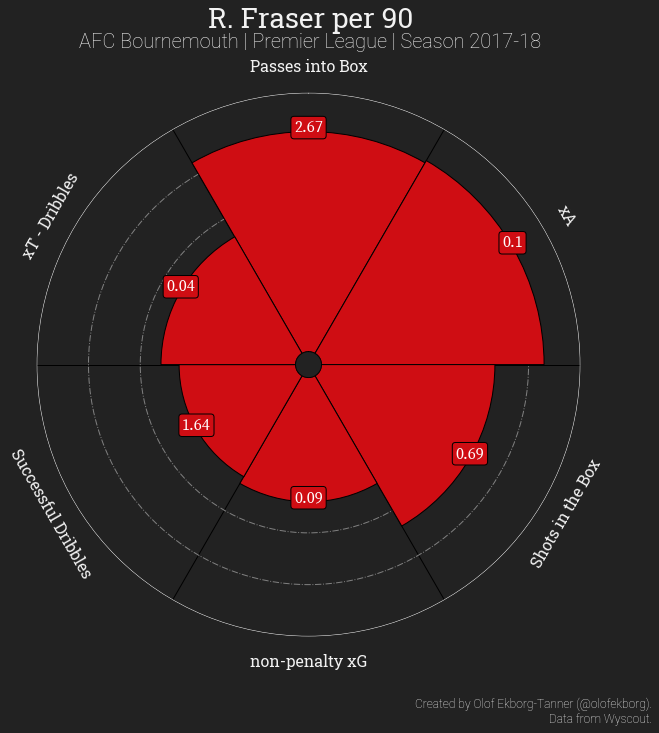

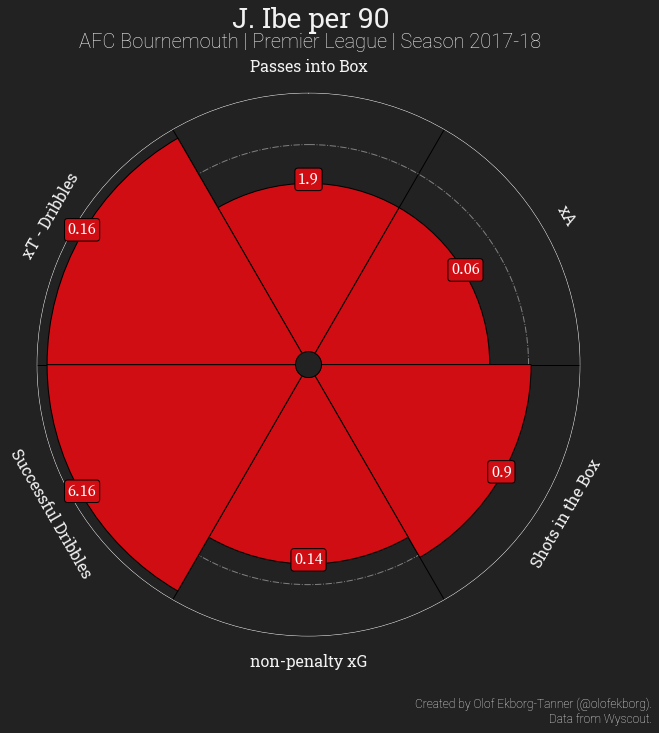

In [73]:
# Plot Bournemouth players
for player in [8959,62224,9739]:
    plot_pizza(player, summary_per_90_pl, dark_mode=True, add_title=True, league_name='Premier League', save_fig=False)

### Bundesliga

In [61]:
# Summaries all metrics in one dataset.
summary_bl = get_summary_data_for_plot('Germany').merge(
    df_sd_bl.groupby('playerId').xT.sum(), on='playerId'
)

# Normalise to minutes played.
summary_per_90_bl = summary_bl.loc[(summary_bl.position == 'Midfielder') & (summary_bl.minutesPlayed > 900),['playerId','shortName','position','foot','teamId']]
for column in summary_bl.columns[6:]:
    summary_per_90_bl[f'{column}_per90'] = summary_bl.apply(lambda x: x[column] * 90 / x['minutesPlayed'], axis=1)

summary_bl = summary_bl.loc[summary_bl.playerId != 51013]

#### Top 10 players list

In [44]:
# set transfer value data
transfermarkt = [
    {'playerId': 105378, 'age': 28, 'market_value':'€10'},
    {'playerId': 14786, 'age': 28, 'market_value': '€12'},
    {'playerId': 134397, 'age':22, 'market_value': '€20'},
    {'playerId': 14816, 'age': 29, 'market_value': '€13'},
    {'playerId': 14727, 'age': 34, 'market_value': '€7'},
    {'playerId': 127796, 'age': 25, 'market_value': '€6'},
    {'playerId': 20475, 'age': 31, 'market_value': '€35'},
    {'playerId': 65596, 'age': 24, 'market_value': '€25'},
    {'playerId': 391530, 'age': 19, 'market_value': '€45'},
    {'playerId': 263614, 'age': 21, 'market_value': '€17'},
]

df_transfer = pd.DataFrame(transfermarkt)

# get team badges from Fotmob
fotmob_team_id = {
    2450: 9790,
    2444: 9823,
    2482: 8226,
    2449: 10189,
    2446: 8178,
    2447: 9789,
    2975: 178475
}

In [46]:
def ax_logo(team_id, ax):
    '''
    Plots the logo of the team at a specific axes.
    Args:
        team_id (int): the id of the team according to Fotmob. You can find it in the url of the team page.
        ax (object): the matplotlib axes where we'll draw the image.
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id}.png'))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

In [67]:
bl_top10 = summary_per_90_bl.merge(df_teams, left_on='teamId', right_on='wyId').sort_values(by='npxG_per90', ascending=False).head(10)
bl_top10['npxG_per90'] = bl_top10.npxG_per90.apply(lambda x: round(x,3))
bl_table = bl_top10.merge(df_transfer)[['shortName','teamId','age','market_value', 'foot','npxG_per90']]

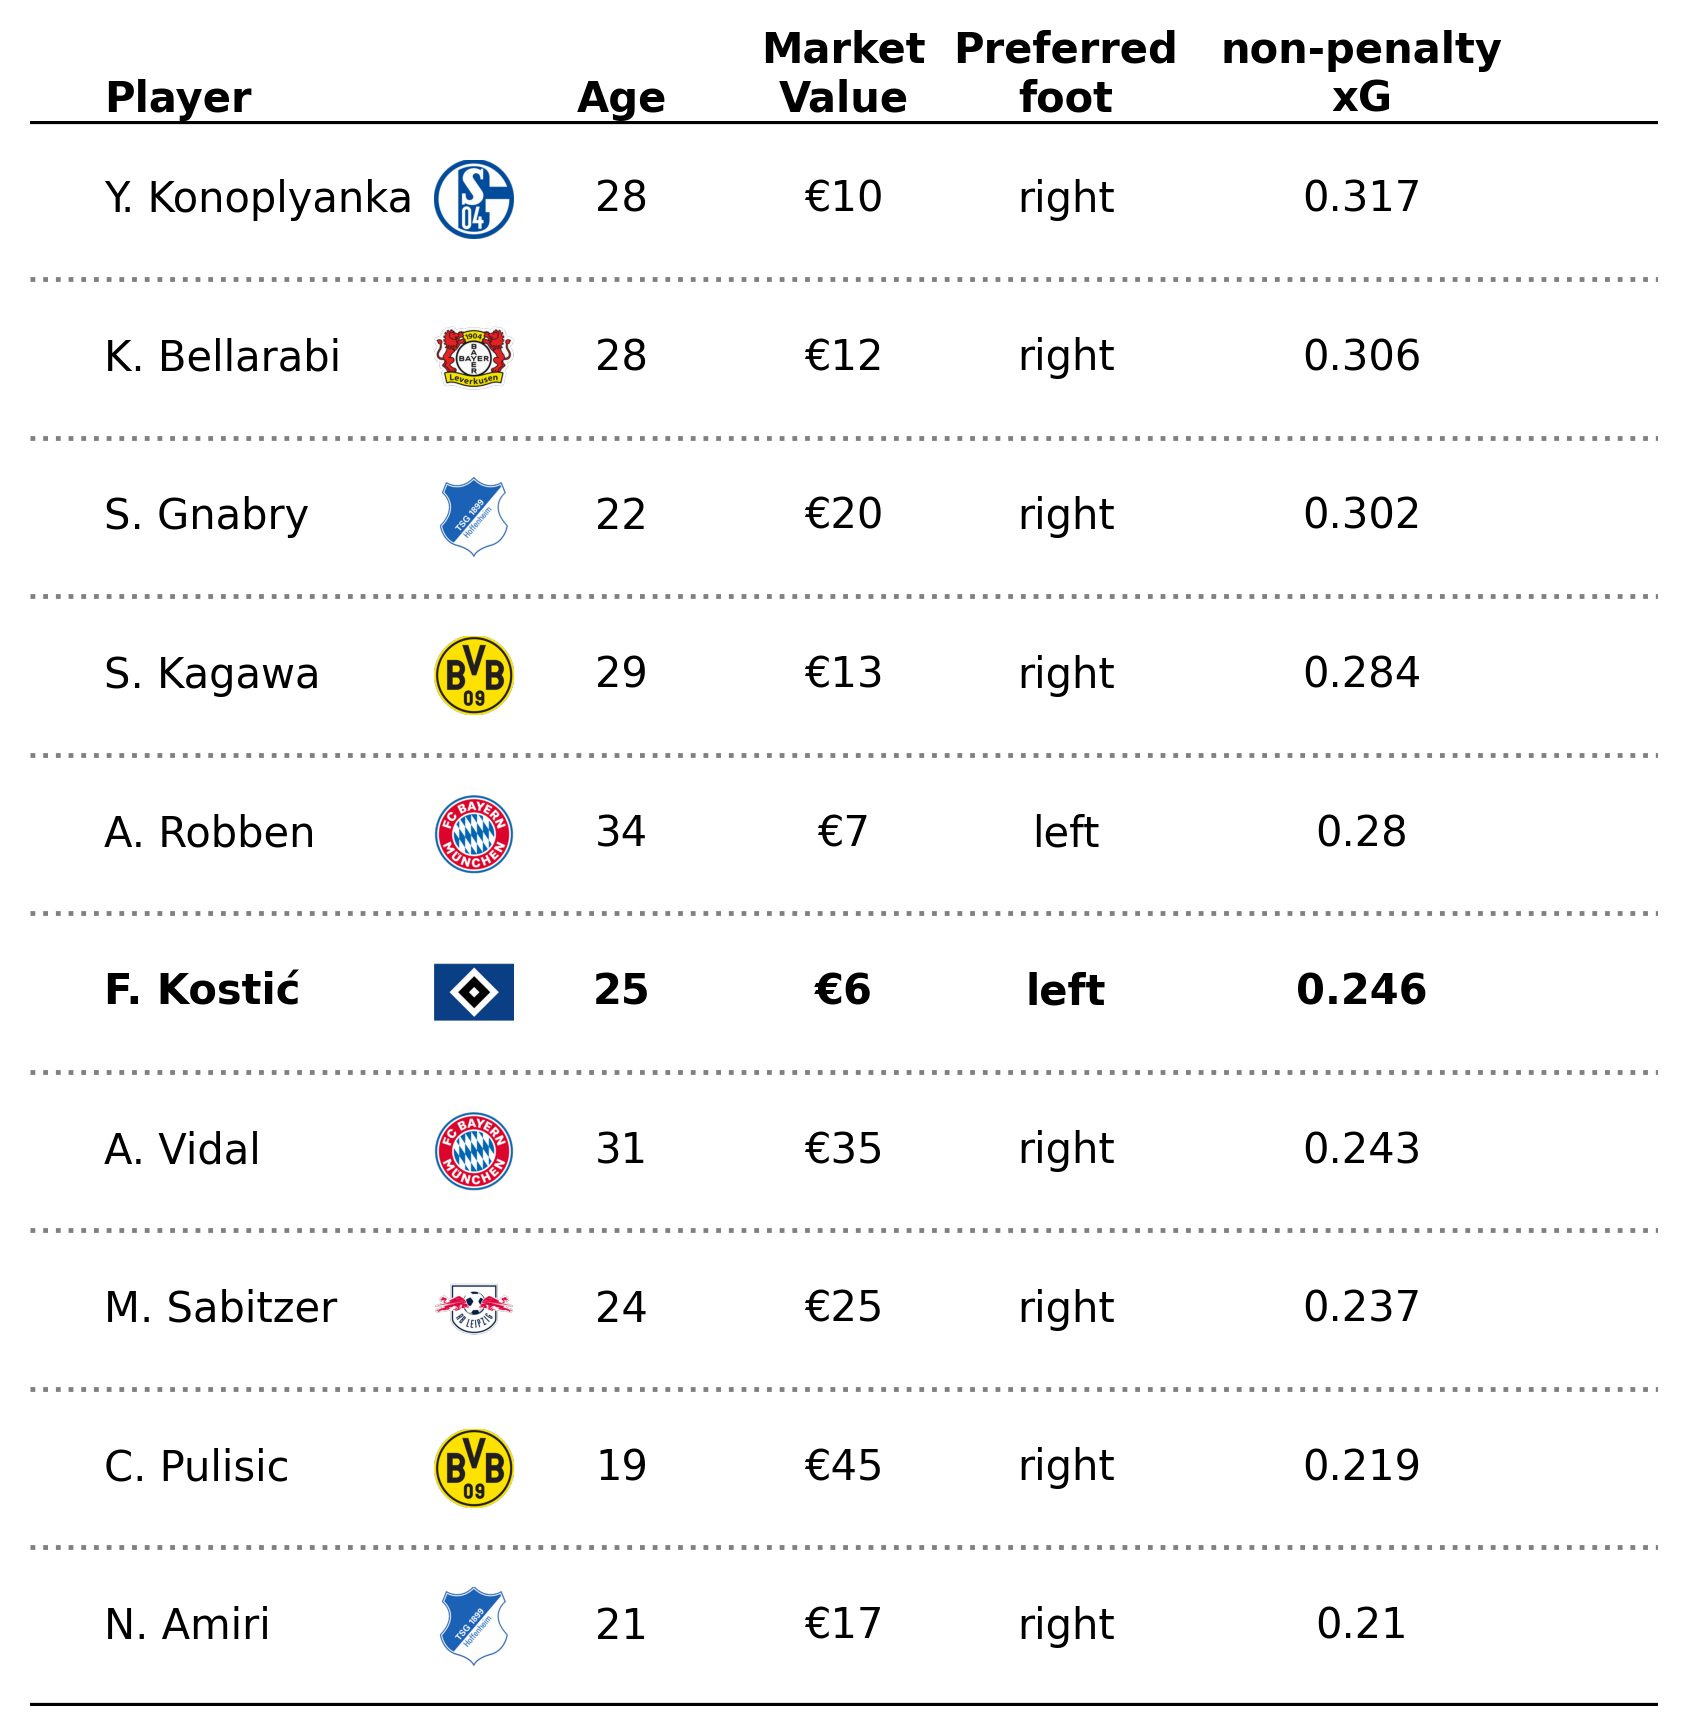

In [69]:
### Plot top 10 list
from PIL import Image
import urllib
import os

fig = plt.figure(figsize=(7,7), dpi=300)
ax = plt.subplot()

nrows = bl_table.shape[0]
ncols = bl_table.shape[1]

ax.set_xlim(0, ncols - 0.5)
ax.set_ylim(0, nrows)

positions = [0.25, 1.5, 2, 2.75, 3.5,4.5]
columns = bl_table.columns

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
        else:
            ha = 'center'
        
        if i == 4:
            weight = 'bold'
        else:
            weight = 'normal'
            
        if j != 1:
            ax.annotate(
                xy=(positions[j], i + 0.5),
                text=bl_table[column].iloc[nrows - i - 1],
                ha=ha,
                va='center',
                weight=weight
            )
        

# Add column names
column_names = ['Player', '','Age', 'Market\nValue', 'Preferred\nfoot', 'non-penalty\nxG']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'left'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold',
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

    
    

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([1.25, 0.25])
ax_point_2 = DC_to_NFC([1.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.25, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(fotmob_team_id[bl_table['teamId'].iloc[nrows - x - 1]], flag_ax)


ax.set_axis_off()

"""
plt.savefig(
    'top_10.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight'
)
"""


plt.show()

### Recommended signing

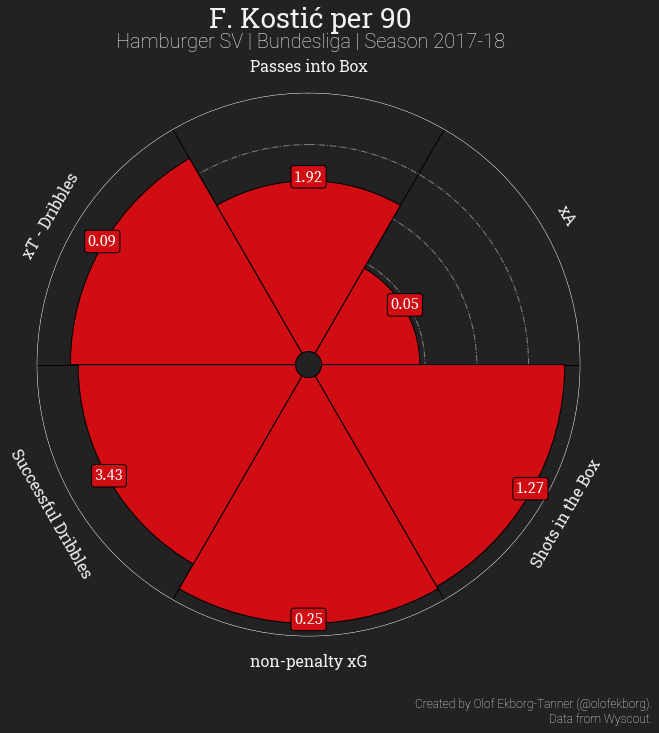

In [74]:
# Plot recommended signing from Bundesliga
plot_pizza(127796, summary_per_90_bl, dark_mode=True, add_title=True, league_name='Bundesliga', save_fig=False)